Data loaded successfully. Shape: (2205, 40)
Cleaned data shape: (2205, 40)
Features (Monetary and Frequency) engineered.


C:\Users\eswar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\eswar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\eswar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\eswar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

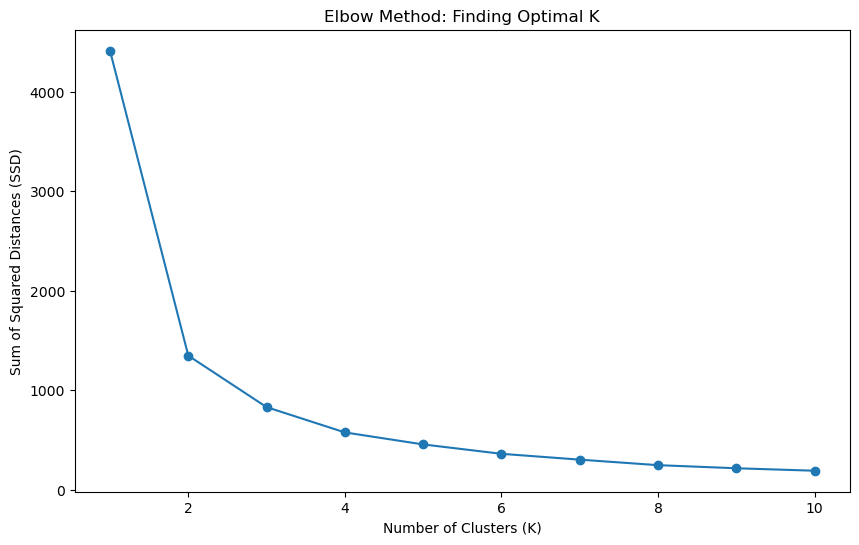

C:\Users\eswar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


K-Means clustering complete with K=4.


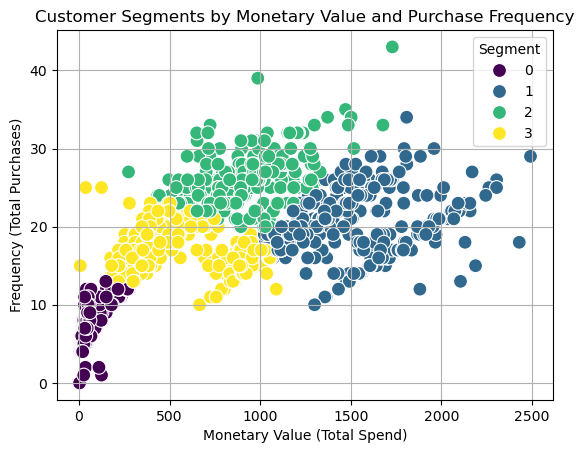


--- Cluster Profile (Mean Values) ---
         Monetary  Frequency
Cluster                     
1         1521.30      20.43
2          901.94      25.72
3          491.41      17.21
0           67.30       7.33

--- Actionable Insights ---

- Segment 1 (PREMIUM/LOYAL):
  > Mean Spend: $1,521 | Mean Orders: 20.4
  > Strategy: Target with **VIP loyalty programs** and exclusive pre-releases.

- Segment 2 (PREMIUM/LOYAL):
  > Mean Spend: $902 | Mean Orders: 25.7
  > Strategy: Target with **VIP loyalty programs** and exclusive pre-releases.

- Segment 3 (PREMIUM/LOYAL):
  > Mean Spend: $491 | Mean Orders: 17.2
  > Strategy: Target with **VIP loyalty programs** and exclusive pre-releases.

- Segment 0 (CHURN RISK):
  > Mean Spend: $67 | Mean Orders: 7.3
  > Strategy: Launch **re-engagement campaigns** with limited-time discounts to win them back.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. SETUP AND DATA LOADING

FILE_NAME = 'C:/Users/eswar/Downloads/ifood_df.csv' 
MONETARY_COL = 'MntTotal'
ID_COL = 'CustomerIndex' # We will use the row index as a unique ID
df = pd.read_csv(FILE_NAME)
df[ID_COL] = df.index
print(f"Data loaded successfully. Shape: {df.shape}")


# 2. DATA CLEANING AND PREPARATION

df.dropna(subset=['Income'], inplace=True) 
df.drop_duplicates(inplace=True)
print(f"Cleaned data shape: {df.shape}")


# 3. FEATURE ENGINEERING (Monetary and Frequency)

purchase_channels = [
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases'
]
df['TotalPurchases'] = df[purchase_channels].sum(axis=1)
features_df = df[[ID_COL, MONETARY_COL, 'TotalPurchases']].copy()
features_df.rename(columns={
    MONETARY_COL: 'Monetary', 
    'TotalPurchases': 'Frequency'
}, inplace=True)

X = features_df[['Monetary', 'Frequency']]
print("Features (Monetary and Frequency) engineered.")


# 4. CUSTOMER SEGMENTATION (K-Means)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ssd = []
K_range = range(1, 11)
for k in K_range:
    # Set n_init=10 to comply with best practices and suppress minor warnings
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, ssd, marker='o')
plt.title('Elbow Method: Finding Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.show()
optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_kmeans.fit(X_scaled)
features_df['Cluster'] = final_kmeans.labels_
print(f"K-Means clustering complete with K={optimal_k}.")


# 5. VISUALIZATION OF SEGMENTS

sns.scatterplot(
    x='Monetary', 
    y='Frequency', 
    hue='Cluster', 
    data=features_df, 
    palette='viridis', 
    s=100
)
plt.title('Customer Segments by Monetary Value and Purchase Frequency')
plt.xlabel('Monetary Value (Total Spend)')
plt.ylabel('Frequency (Total Purchases)')
plt.legend(title='Segment')
plt.grid(True)
plt.show()


# 6. INSIGHTS AND RECOMMENDATIONS

cluster_summary = features_df.groupby('Cluster')[['Monetary', 'Frequency']].mean().sort_values(by='Monetary', ascending=False)

print("\n--- Cluster Profile (Mean Values) ---")
print(cluster_summary.round(2))
median_monetary = features_df['Monetary'].median()
median_frequency = features_df['Frequency'].median()

print("\n--- Actionable Insights ---")

for cluster_label in cluster_summary.index:
    monetary = cluster_summary.loc[cluster_label, 'Monetary']
    frequency = cluster_summary.loc[cluster_label, 'Frequency']
    
    # Assign segment type based on mean vs. median thresholds
    if monetary > median_monetary and frequency > median_frequency:
        segment_type = "PREMIUM/LOYAL"
        recommendation = "Target with **VIP loyalty programs** and exclusive pre-releases."
    elif monetary > median_monetary and frequency <= median_frequency:
        segment_type = "BIG SPENDERS"
        recommendation = "Focus on **increasing frequency** through follow-up and targeted content."
    elif monetary <= median_monetary and frequency > median_frequency:
        segment_type = "FREQUENT/BUDGET"
        recommendation = "Implement **upselling strategies** and bundle deals to boost average order value."
    else:
        segment_type = "CHURN RISK"
        recommendation = "Launch **re-engagement campaigns** with limited-time discounts to win them back."
    
    print(f"\n- Segment {cluster_label} ({segment_type}):")
    print(f"  > Mean Spend: ${monetary:,.0f} | Mean Orders: {frequency:.1f}")
    print(f"  > Strategy: {recommendation}")